In [43]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import cv2
import os
from skimage import io, color
import os
import matplotlib.pyplot as plt
import random
from skimage import transform
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.models import load_model


In [ ]:
! wget http://images.cocodataset.org/zips/test2017.zip

--2024-11-25 11:12:32--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.42.228, 3.5.27.207, 3.5.12.77, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.42.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip        100%[===================>]   6.19G  16.1MB/s    in 6m 36s  

2024-11-25 11:19:09 (16.0 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]



In [ ]:
! unzip test2017.zip -d coco_dataset

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: coco_dataset/test2017/000000251604.jpg  
 extracting: coco_dataset/test2017/000000145034.jpg  
 extracting: coco_dataset/test2017/000000234833.jpg  
 extracting: coco_dataset/test2017/000000025927.jpg  
 extracting: coco_dataset/test2017/000000393116.jpg  
 extracting: coco_dataset/test2017/000000536478.jpg  
 extracting: coco_dataset/test2017/000000365460.jpg  
 extracting: coco_dataset/test2017/000000089887.jpg  
 extracting: coco_dataset/test2017/000000274928.jpg  
 extracting: coco_dataset/test2017/000000310028.jpg  
 extracting: coco_dataset/test2017/000000229793.jpg  
 extracting: coco_dataset/test2017/000000394339.jpg  
 extracting: coco_dataset/test2017/000000564538.jpg  
 extracting: coco_dataset/test2017/000000440585.jpg  
 extracting: coco_dataset/test2017/000000541512.jpg  
 extracting: coco_dataset/test2017/000000395525.jpg  
 extracting: coco_dataset/test2017/000000235435.jpg  
 ext

In [ ]:
%%bash

# Define source and target directories
SOURCE_DIR="coco_dataset/val2017/"
TARGET_DIR="coco_dataset/val2017_subset/"

# Create the target directory if it doesn't exist
mkdir -p "$TARGET_DIR"

# Find the first 10,000 files in the source directory and move them to the target directory
find "$SOURCE_DIR" -type f | head -n 15000 | while read file; do
    mv "$file" "$TARGET_DIR"
done

echo "Moved the first 15,000 images to $TARGET_DIR."


Moved the first 10,000 images to coco_dataset/val2017_subset/.


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from pathlib import Path

data_dir = 'coco_dataset/val2017_subset/'
image_size = (128, 128)
batch_size = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)

    return grayscale/255.0, image/255.0


colorization_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)




Found 15000 files.


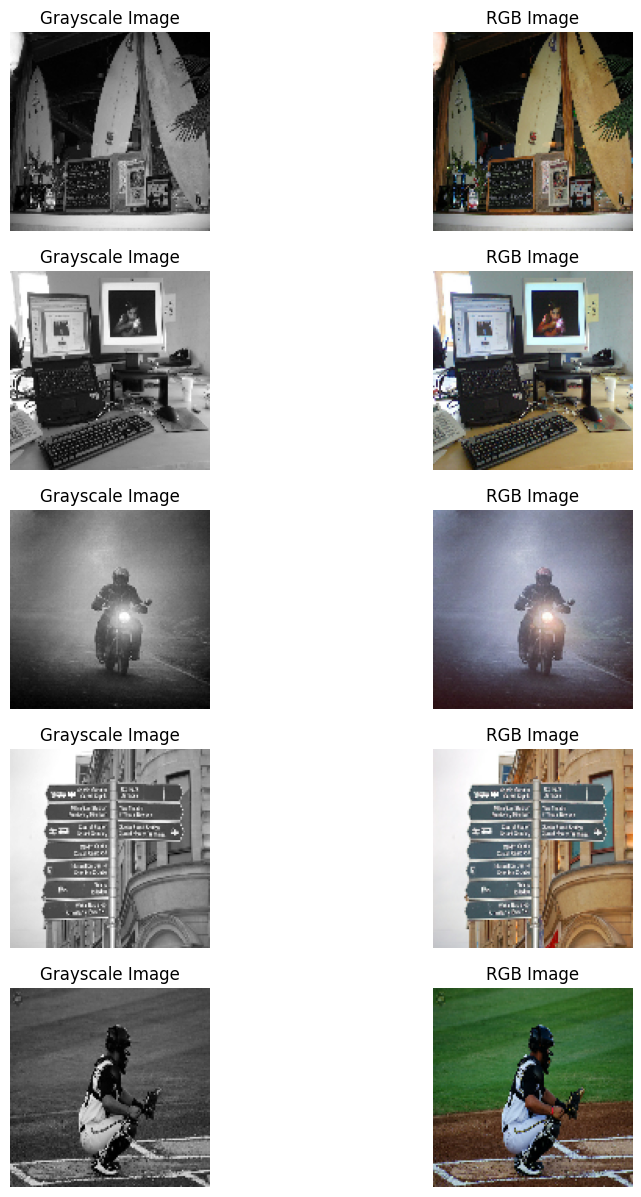

In [ ]:
def display_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(10, num_images * 3))
    count = 0
    for grayscale_batch, rgb_batch in dataset.take(1): 
        for i in range(num_images):
            if count >= len(grayscale_batch):  # Stop if fewer images than num_images in batch
                break
            grayscale_image = grayscale_batch[i].numpy().squeeze()  
            rgb_image = rgb_batch[i].numpy() 

            # Plot grayscale image
            plt.subplot(num_images, 2, 2 * count + 1)
            plt.imshow(grayscale_image, cmap='gray')
            plt.title("Grayscale Image")
            plt.axis("off")
            # Plot RGB image
            plt.subplot(num_images, 2, 2 * count + 2)
            plt.imshow(rgb_image)
            plt.title("RGB Image")
            plt.axis("off")

            count += 1
            if count >= num_images:
                break
    plt.show()

display_from_dataset(train_dataset, num_images=5)


In [ ]:
# print(train_dataset.take(1))
for batch in train_dataset.take(1):
    print("Shape des images:", len(batch[0]), len(batch[1]))

In [ ]:
print(dataset)
print(train_dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>


In [45]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, BatchNormalization, Input

def build_colorization_model(input_shape):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    print(input_shape)
    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model

from keras.applications import VGG19

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False  

feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)
def perceptual_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(feature_extractor(y_true) - feature_extractor(y_pred)))
    return loss

# Assuming image_size is (150, 150)
input_shape = (image_size[0], image_size[1], 1)  # Grayscale images have 1 channel
model = build_colorization_model(input_shape)

# Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss = perceptual_loss, metrics=['mae'])

model.summary()

(128, 128, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,575,619 (17.45 MB)

 Trainable params: 4,575,619 (17.45 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
saved_model = load_model('colorization_model_128x128_100epochs_10000imgs_perceptual_15000.keras', custom_objects={'perceptual_loss': perceptual_loss})


In [ ]:

# # Entraîner le modèle
# saved_history = saved_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=15
# )



Epoch 1/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 158s 203ms/step - loss: 0.0162 - mae: 0.0916 - val_loss: 0.0137 - val_mae: 0.0860
Epoch 2/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms/step - loss: 0.0129 - mae: 0.0817 - val_loss: 0.0117 - val_mae: 0.0766
Epoch 3/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - loss: 0.0123 - mae: 0.0793 - val_loss: 0.0110 - val_mae: 0.0719
Epoch 4/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - loss: 0.0120 - mae: 0.0777 - val_loss: 0.0108 - val_mae: 0.0716
Epoch 5/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - loss: 0.0117 - mae: 0.0765 - val_loss: 0.0111 - val_mae: 0.0731
Epoch 6/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 116s 166ms/step - loss: 0.0117 - mae: 0.0761 - val_loss: 0.0112 - val_mae: 0.0741
Epoch 7/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 113s 147ms/step - loss: 0.0115 - mae: 0.0754 - val_loss: 0.0109 - val_mae: 0.0726
Epoch 8/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 140s 144ms/step - loss: 0.0115 - mae: 0.0751 - val_loss: 0.0117 - val_mae: 0.0769
Epoch 9/100
376/

In [21]:

# Entraîner le modèle
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs = 100,
)



Epoch 1/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - loss: 0.0778 - mae: 0.1024 - val_loss: 0.2352 - val_mae: 0.1053
Epoch 2/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0750 - mae: 0.1021 - val_loss: 0.2370 - val_mae: 0.1057
Epoch 3/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 170ms/step - loss: 0.0764 - mae: 0.1027 - val_loss: 0.2342 - val_mae: 0.1052
Epoch 4/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 170ms/step - loss: 0.0739 - mae: 0.1021 - val_loss: 0.2344 - val_mae: 0.1066
Epoch 5/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 170ms/step - loss: 0.0751 - mae: 0.1024 - val_loss: 0.2372 - val_mae: 0.1051
Epoch 6/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - loss: 0.0734 - mae: 0.1024 - val_loss: 0.2417 - val_mae: 0.1060
Epoch 7/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - loss: 0.0741 - mae: 0.1020 - val_loss: 0.2411 - val_mae: 0.1038
Epoch 8/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 70s 169ms/step - loss: 0.0743 - mae: 0.1023 - val_loss: 0.2342 - val_mae: 0.1035
Epoch 9/100
376/376 ━━━━

In [23]:
model.save('colorization_model_128x128_100epochs_10000imgs_perceptual_15000.keras')


In [ ]:

# Charger une image grayscale pour prédiction
def load_grayscale_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  
    image = tf.image.resize(image, target_size) / 255.0  
    return tf.expand_dims(image, axis=0)  


def prediction_examples(model, data):
    for grayscale_batch, rgb_batch in data.take(1):
        predicted_rgb = model.predict(grayscale_batch)
        # Initialize PSNR and SSIM lists
        psnr_scores = []
        ssim_scores = []
        plt.figure(figsize=(15, 10))
        for i in range(5):  # Display 5 examples
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_rgb[i], 0, 1)  # Ensure predictions are in [0, 1]
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            plt.subplot(4, 5, i + 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_batch[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(4, 5, i + 6)
            plt.title("True RGB")
            plt.imshow(true_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 11)
            plt.title("Predicted RGB")
            plt.imshow(pred_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 16)
            plt.title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Average PSNR: {np.mean(psnr_scores):.2f}")
        print(f"Average SSIM: {np.mean(ssim_scores):.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


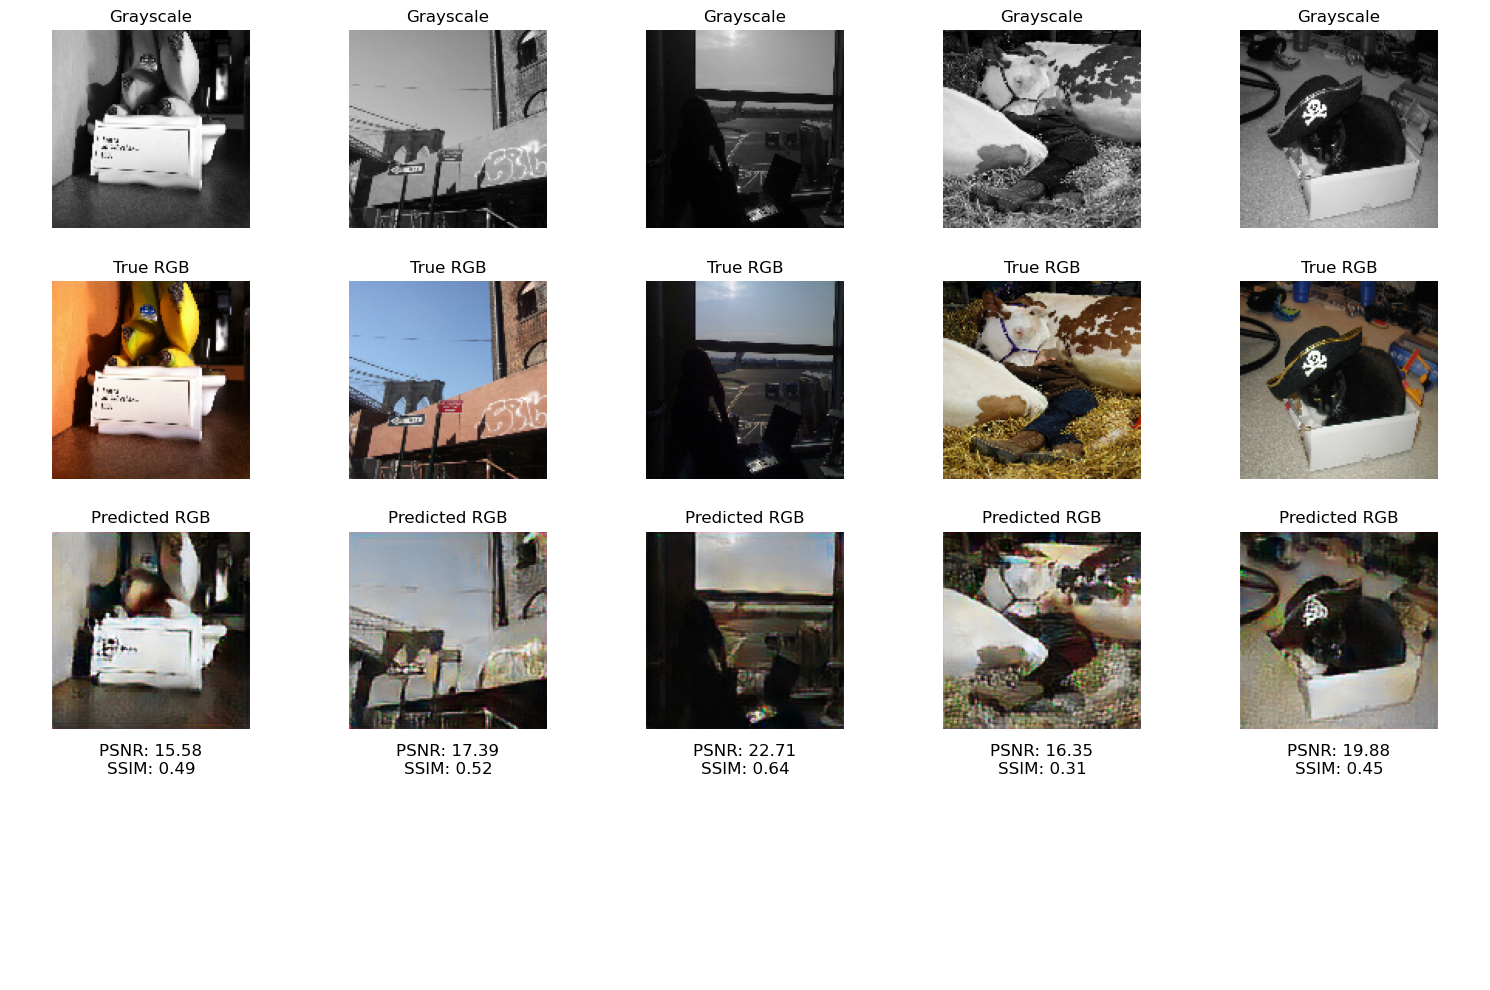

Average PSNR: 18.38
Average SSIM: 0.48


In [36]:
prediction_examples(model, val_dataset)

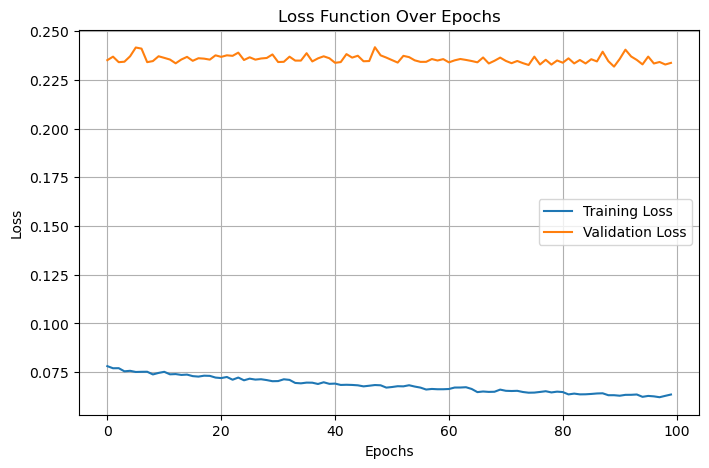

In [39]:

# Plot the loss function
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

In [ ]:

def evaluate_model_on_validation(model, val_data):
    psnr_scores = []
    ssim_scores = []

    # Iterate over the entire validation dataset
    for grayscale_batch, rgb_batch in val_data:
        predicted_batch = model.predict(grayscale_batch)
        # Iterate through the batch
        for i in range(grayscale_batch.shape[0]):  
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_batch[i], 0, 1) 
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)
    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)
    print(f"Mean PSNR: {mean_psnr:.2f}")
    print(f"Mean SSIM: {mean_ssim:.2f}")

    return mean_psnr, mean_ssim

In [38]:
evaluate_model_on_validation(model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

(17.0843613574687, 0.38648692)

In [ ]:
from skimage.color import rgb2gray, rgb2lab
from skimage.restoration import estimate_sigma

# NIQE Calculation (Placeholder Example)
def calculate_niqe(image):
    """
    Calculate the NIQE score for an image.
    A placeholder logic using noise sigma as a proxy for demonstration.
    In practice, use a pre-trained NIQE model.
    """
    gray_image = rgb2gray(image)
    sigma = estimate_sigma(gray_image, average_sigmas=True)
    niqe_score = sigma
    return niqe_score

def calculate_colorfulness(image):
    """
    Calculate the colorfulness metric for an RGB image.
    """
    (R, G, B) = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    std_rg, mean_rg = np.std(rg), np.mean(rg)
    std_yb, mean_yb = np.std(yb), np.mean(yb)
    colorfulness = np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)
    return colorfulness

def calculate_brightness_contrast(image):
    """
    Calculate brightness and contrast for an image.
    Brightness is the mean luminance, and contrast is the standard deviation.
    """
    luminance = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    brightness = np.mean(luminance)
    contrast = np.std(luminance)

    return brightness, contrast

# LAB Color Balance Visualization
def analyze_color_balance(image):
    """
    Analyze the color balance of an image by visualizing LAB histograms.
    """
    lab_image = rgb2lab(image)
    L, a, b = lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.hist(L.ravel(), bins=256, color='gray'); plt.title("Luminance (L)")
    plt.subplot(1, 3, 2); plt.hist(a.ravel(), bins=256, color='red'); plt.title("Chrominance (a)")
    plt.subplot(1, 3, 3); plt.hist(b.ravel(), bins=256, color='blue'); plt.title("Chrominance (b)")
    plt.tight_layout()
    plt.show()




In [ ]:
if __name__ == "__main__":
    from skimage import io

    # Load a sample image
    # image_url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'
    # image = io.imread(image_url)
    image = rgb_images[1]
    # Ensure the image is normalized to range [0, 1]
    if image.max() > 1.0:
        image = image / 255.0

    # Calculate metrics
    niqe_score = calculate_niqe(image)
    colorfulness = calculate_colorfulness(image)
    brightness, contrast = calculate_brightness_contrast(image)

    # Display results
    print(f"NIQE Score: {niqe_score}")
    print(f"Colorfulness: {colorfulness}")
    print(f"Brightness: {brightness}")
    print(f"Contrast: {contrast}")

    analyze_color_balance(image)